In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [158]:
import glob
import warnings
import numpy as np
import pylab as plt

from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ, primeX, primeY, primeZ
from parabolas import loadLeicaData, fitParabola, parabola, fitLeicaData
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, radialMask, gridLimits, stride, rolling_stat, getRollingStat
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly, zernikeFitLS
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [3]:
def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, 
                          max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        
        x_ = np.ma.masked_where(mask, x)
        y_ = np.ma.masked_where(mask, y)
        z_ = np.ma.masked_where(mask, z)
        
        fit = fitLeicaData(x_.compressed(), y_.compressed(), z_.compressed(), 
                           guess, bounds=bounds, f_scale=f_scale, ftol=ftol, 
                           xtol=xtol, max_nfev=max_nfev)
        
        xdr, ydr, zdr = alignXYZ(x, y, z, fit.x)
        
        zp = parabola(xdr, ydr, fit.x[0])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = binary_dilation(res.mask, iterations=2)
        guess = fit.x
    
    return fit, mask


def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    
    xr, yr, zr = shiftRotateXYZ(x, y, z, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    xg, yg, zg = regridXYZ(xr, yr, zr, n=n)
    
    return xg, yg, zg


def alignXYZ(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr

In [136]:
n = 512
iters = 1
nZern = 36
guess = [60., 2.5, -0.7, -49., 0.2, 0.]
kernel = Gaussian2DKernel(x_stddev=17.75)
iz = 4
izv = -562
zcoef = np.zeros(nZern)
zcoef[iz] = izv
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [5]:
%%time
#refScan = "{0}/ref_average.ptx.csv".format(scanDir)
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=178.)

CPU times: user 1min, sys: 2.75 s, total: 1min 3s
Wall time: 58.8 s


In [140]:
%%time
sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) # C4=-518
#sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486
#sigScan = "{0}/2020_03_16_03:27:25.ptx.csv".format(scanDir) # C4=-167
#sigScan = "{0}/2020_03_16_06:43:17.ptx.csv".format(scanDir) # C4=-562
#sigScan = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir) # C13=-534
#sigScan = "{0}/2020_03_16_05:54:35.ptx.csv".format(scanDir) # C13=-169
#sigScan = "{0}/2020_03_16_06:18:53.ptx.csv".format(scanDir) # C13=-56
#sigScan = "{0}/2020_03_16_09:09:14.ptx.csv".format(scanDir) # C13=-534
#sigScan = "{0}/2020_03_16_04:16:39.ptx.csv".format(scanDir) # C7=-545
#sigScan = "{0}/2020_03_16_04:41:09.ptx.csv".format(scanDir) # C7=-144
#sigScan = "{0}/2020_03_16_07:56:13.ptx.csv".format(scanDir) # C7=-554
xs, ys, zs = prepareData(sigScan, n=n, rot=178.)

CPU times: user 6.53 s, sys: 2.62 s, total: 9.15 s
Wall time: 4.74 s


In [141]:
xrg, yrg, zrg = xr, yr, zr
xsg, ysg, zsg = xs, ys, zs

In [142]:
%%time
zrgs = convolve(zrg, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
#zrgs[~radialMask(xr, yr, 48)] = np.nan

CPU times: user 6.19 s, sys: 23.4 ms, total: 6.21 s
Wall time: 6.21 s


In [143]:
%%time
zrsFit, zrsMask = parabolaFitIterations(xrg, yrg, zrgs,
                                        guess=guess, bounds=None, iters=10, 
                                        max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)

CPU times: user 5min 5s, sys: 4min 27s, total: 9min 33s
Wall time: 25.1 s


In [144]:
%%time
zsgs = convolve(zsg, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
#zsgs[~radialMask(xs, ys, 48)] = np.nan

CPU times: user 5.81 s, sys: 0 ns, total: 5.81 s
Wall time: 5.8 s


In [145]:
%%time
zssFit, zssMask = parabolaFitIterations(xsg, ysg, zsgs,
                                        guess=guess, bounds=None, iters=10, 
                                        max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)

CPU times: user 4min 55s, sys: 4min 20s, total: 9min 15s
Wall time: 24.9 s


In [146]:
print(zrsFit.x)
print(zssFit.x)
print(zrsFit.x - zssFit.x)

[ 6.00601972e+01  2.44724282e+00 -9.91700723e-01 -4.91923672e+01
  2.19793555e-01 -5.12147296e-03]
[ 6.00658279e+01  2.44798127e+00 -9.82928332e-01 -4.91911724e+01
  2.19692917e-01 -5.09351389e-03]
[-5.63071470e-03 -7.38450024e-04 -8.77239105e-03 -1.19481577e-03
  1.00637777e-04 -2.79590711e-05]


In [147]:
pFitR = np.copy(zrsFit.x)
pFitS = np.copy(zssFit.x)
#pFitR[3] = 0
#pFitS[3] = 0
print(pFitR)
print(pFitS)

[ 6.00601972e+01  2.44724282e+00 -9.91700723e-01 -4.91923672e+01
  2.19793555e-01 -5.12147296e-03]
[ 6.00658279e+01  2.44798127e+00 -9.82928332e-01 -4.91911724e+01
  2.19692917e-01 -5.09351389e-03]


In [148]:
%%time
xra, yra, zra = alignXYZ(xrg, yrg, zrg, pFitR)
xsa, ysa, zsa = alignXYZ(xsg, ysg, zsg, pFitS)

CPU times: user 362 ms, sys: 271 ms, total: 633 ms
Wall time: 38.2 ms


In [149]:
%%time
xmin, xmax = gridLimits(xsa, xra)
ymin, ymax = gridLimits(ysa, yra)
xrag, yrag, zrag = regridXYZ(xra, yra, zra, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsag, ysag, zsag = regridXYZ(xsa, ysa, zsa, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 23.3 s, sys: 2.22 s, total: 25.5 s
Wall time: 21.1 s
Parser   : 138 ms


<IPython.core.display.Javascript object>


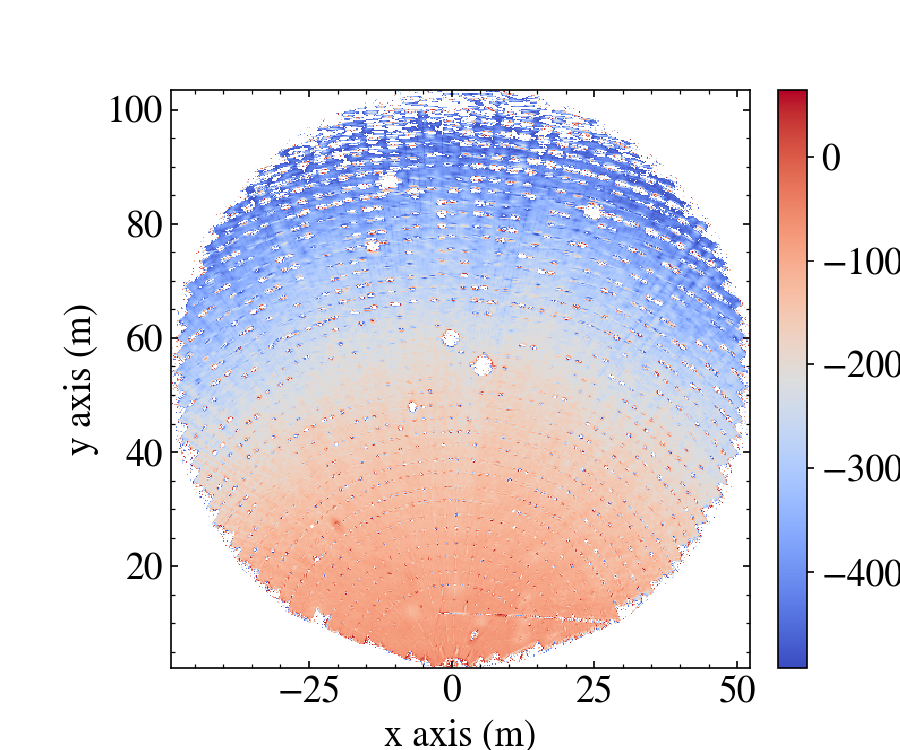

In [150]:
diff = sigma_clip(np.ma.masked_invalid(zsag - zrag), 2.5)
#diff = diff - np.nanmean(diff[~radialMask(xrag, yrag, 2)])
#diff[~radialMask(xrag, yrag, 50)] = np.nan
#diff = np.ma.masked_invalid(diff)
vmin = np.nanmin(diff*1e6)
vmax = np.nanmax(diff*1e6)
surfacePlot(xrag, yrag, diff.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

In [151]:
from astropy.stats.biweight import biweight_scale, biweight_location

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


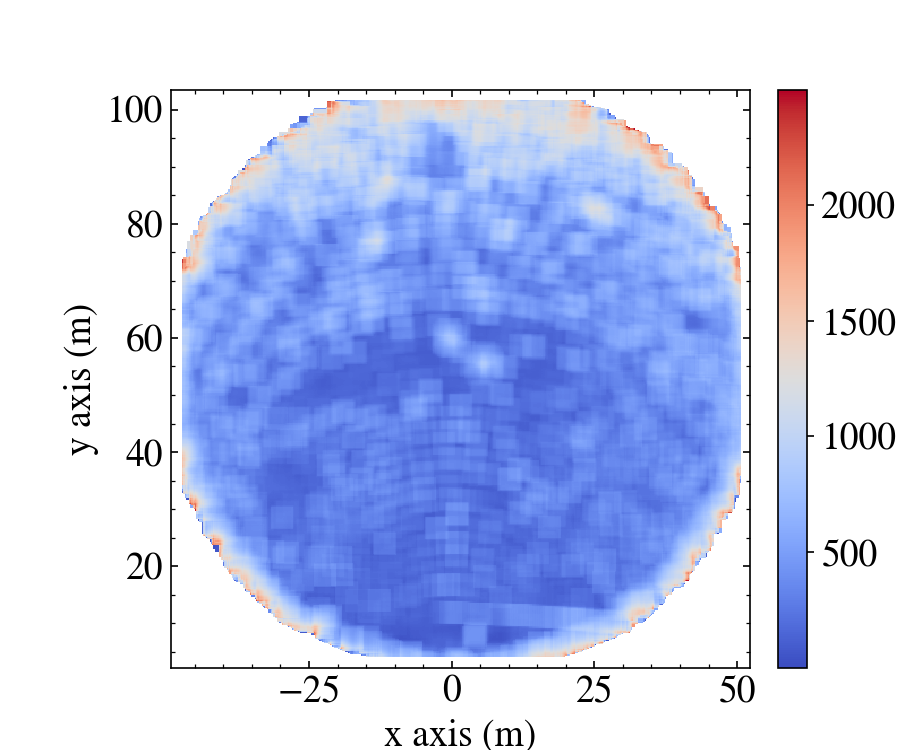

<IPython.core.display.Javascript object>


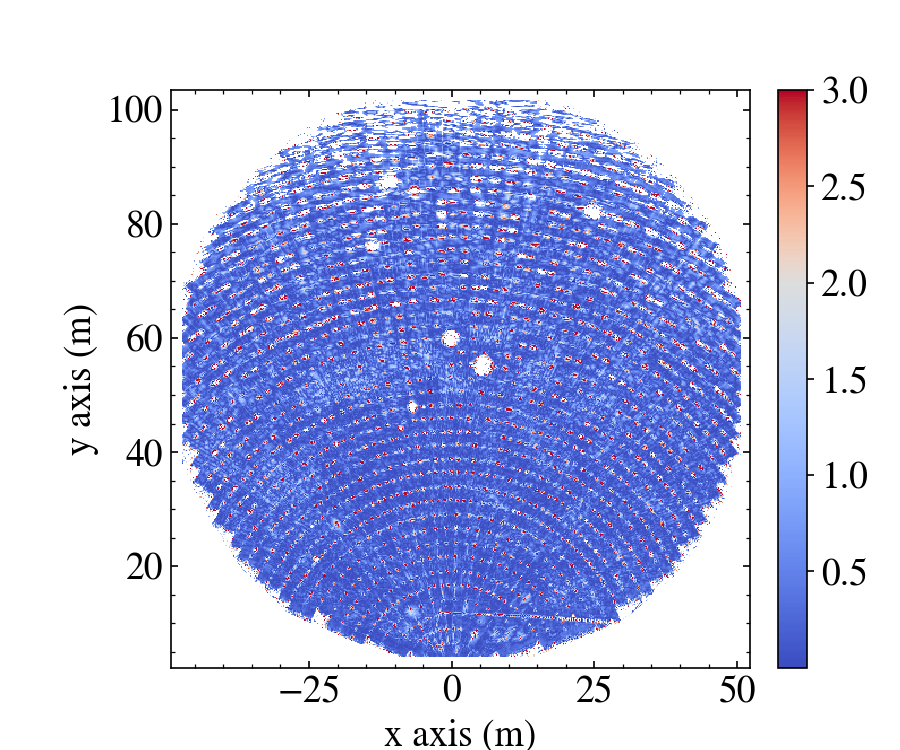

CPU times: user 2.27 s, sys: 1.05 s, total: 3.32 s
Wall time: 3.32 s


In [152]:
%%time
window = (20,20)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #diff_rms = getRollingStat(diff, func=biweight_scale, window=window, **{"ignore_nan":True})
    diff_rms = getRollingStat(diff, func=np.nanstd, window=window)
    #diff_avg = getRollingStat(diff, func=biweight_location, window=window, **{"ignore_nan":True})
    diff_avg = getRollingStat(diff, func=np.nanmean, window=window)
diff_rms = np.ma.masked_where(diff_rms == 0, diff_rms)
mask = (abs(diff - diff_avg)/diff_rms > 2) | (diff_rms == 0) #| (diff_rms >= np.nanstd(diff))

vmin = np.nanmin(diff_rms*1e6)
vmax = np.nanmax(diff_rms*1e6)
surfacePlot(xrag, yrag, diff_rms.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

zscore = abs(diff - diff_avg)/diff_rms
vmin = np.nanmin(zscore)
vmax = np.nanmax(zscore)
surfacePlot(xrag, yrag, zscore.T, vMin=vmin, vMax=3, midPoint=2)

<IPython.core.display.Javascript object>


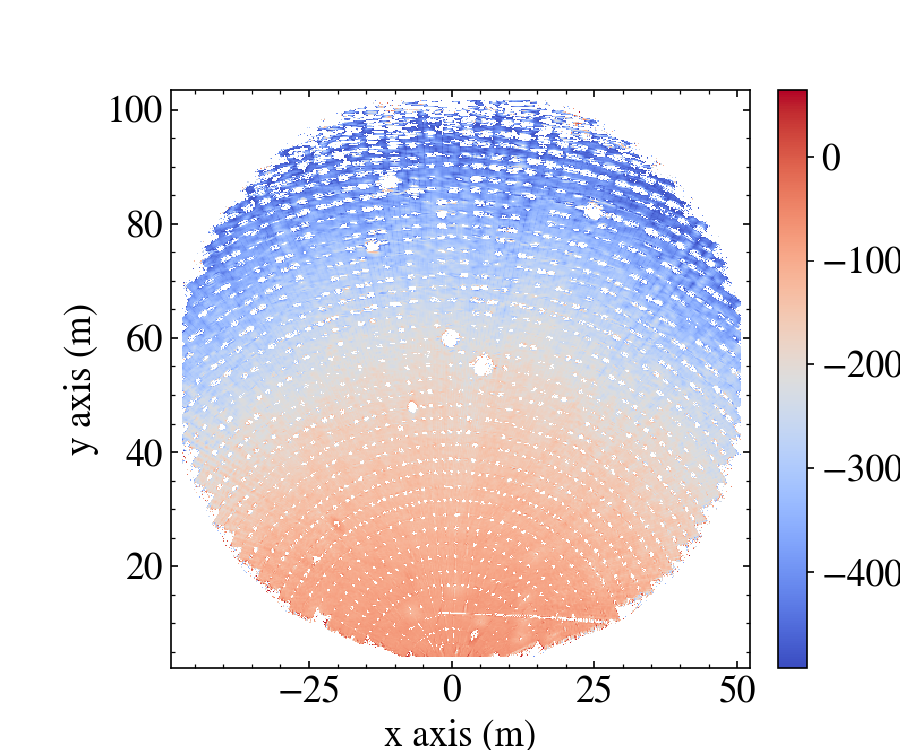

In [153]:
mdiff = sigma_clip(np.ma.masked_where(mask, diff))
vmin = np.nanmin(mdiff*1e6)
vmax = np.nanmax(mdiff*1e6)
surfacePlot(xrag, yrag, mdiff.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

In [154]:
kernel_ = Gaussian2DKernel(x_stddev=10)
smdiff = convolve(mdiff, kernel_, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                  normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
smdiff = np.ma.masked_invalid(smdiff)

<IPython.core.display.Javascript object>


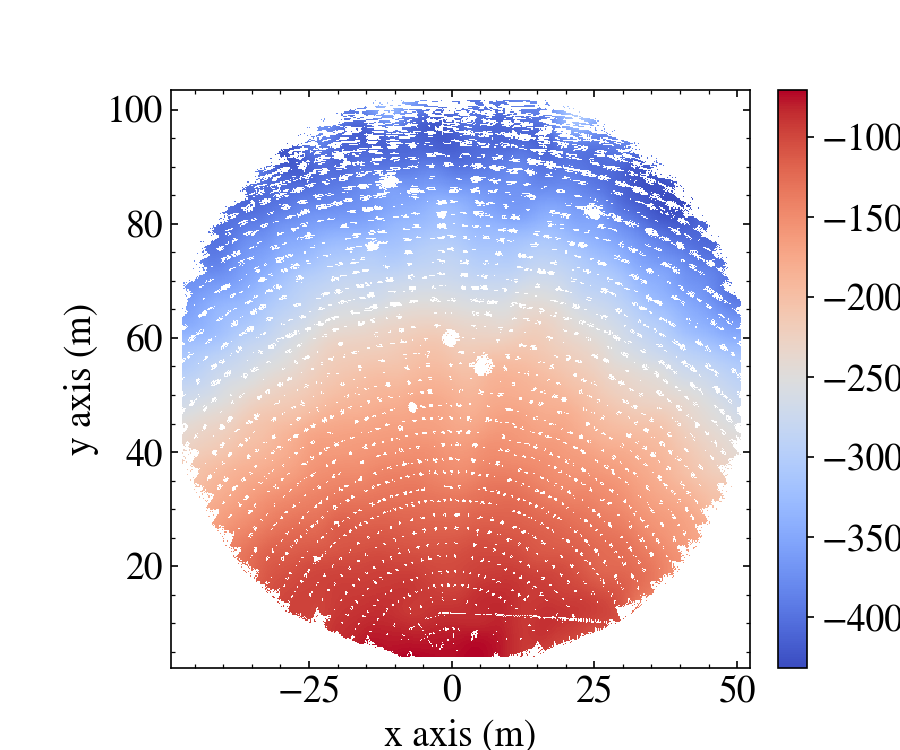

In [155]:
vmin = np.nanmin(smdiff*1e6)
vmax = np.nanmax(smdiff*1e6)
surfacePlot(xrag, yrag, smdiff.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

<IPython.core.display.Javascript object>


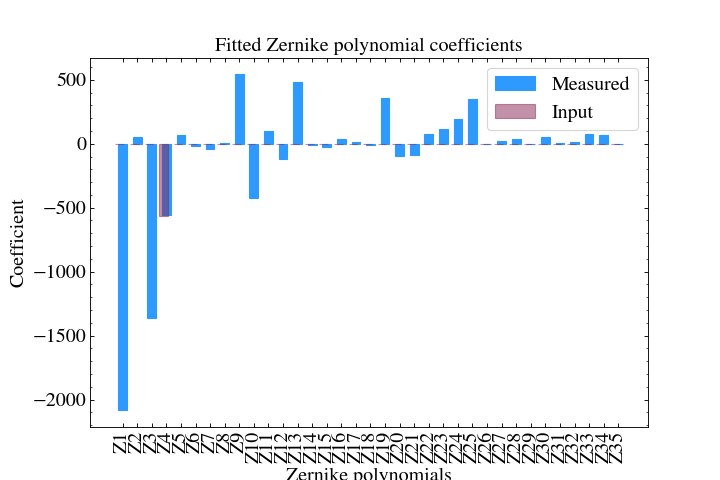

-558.7515573767089


In [168]:
fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs[iz]*1e6)

<IPython.core.display.Javascript object>


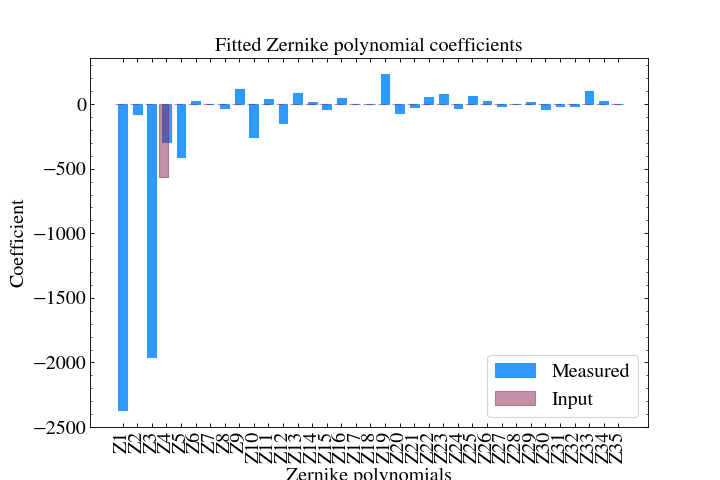

-292.753136331591
CPU times: user 4min 39s, sys: 25.3 s, total: 5min 4s
Wall time: 4min 5s


In [166]:
%%time
#fl_fs = getZernikeCoeffs(smdiff.filled(0)[::-1].T, 36, norm='active-surface')
zfit = zernikeFitLS(xrag[~np.isnan(diff.filled(np.nan))], yrag[~np.isnan(diff.filled(np.nan))], 
                    diff[~np.isnan(diff.filled(np.nan))], np.zeros(36))
fl_fs = zfit.x
#window = (15,15)
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
#    diff_rms_ = getRollingStat(diff, func=np.nanstd, window=window)
#fl_fs = zernikeWLS(xrag, yrag, mdiff[::-1,::-1], nZern, weights=np.power(diff_rms[::-1,::-1], -2.))
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs[iz]*1e6)

<IPython.core.display.Javascript object>


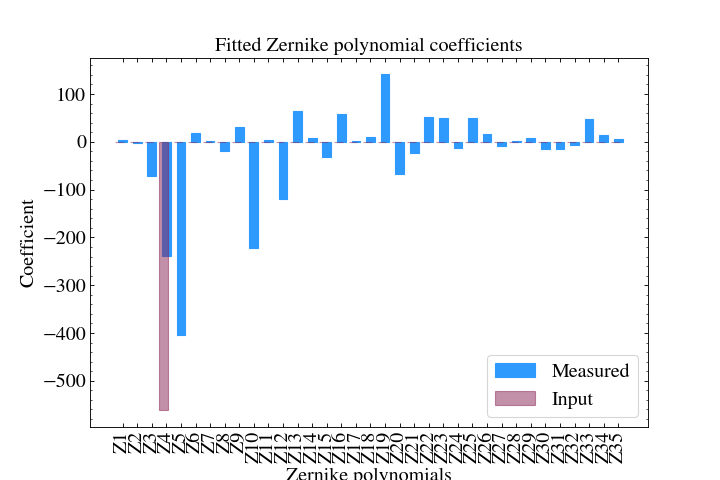

In [163]:
fl_fs_sub2 = np.copy(zfit.x)
zpoly2 = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub2[:4])
diff2 = smdiff - zpoly2
zfit_ = zernikeFitLS(xrag[~np.isnan(diff2.filled(np.nan))], yrag[~np.isnan(diff2.filled(np.nan))], 
                     diff2[~np.isnan(diff2.filled(np.nan))], np.zeros(36))
barChartPlot(np.arange(1,36), zfit_.x[1:36]*1e6, expected=zcoef[1:36])

In [164]:
print(zfit_.x[iz]*1e6)

-238.40881393353115


Number of iterations: 2


<IPython.core.display.Javascript object>


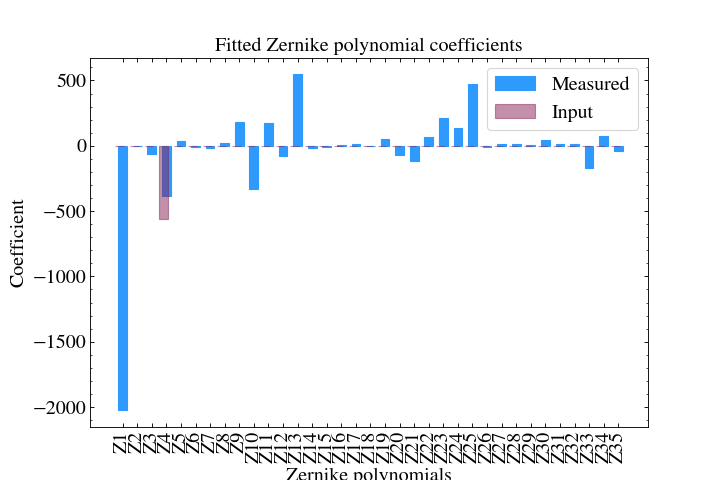

-386.10789231734697


<IPython.core.display.Javascript object>


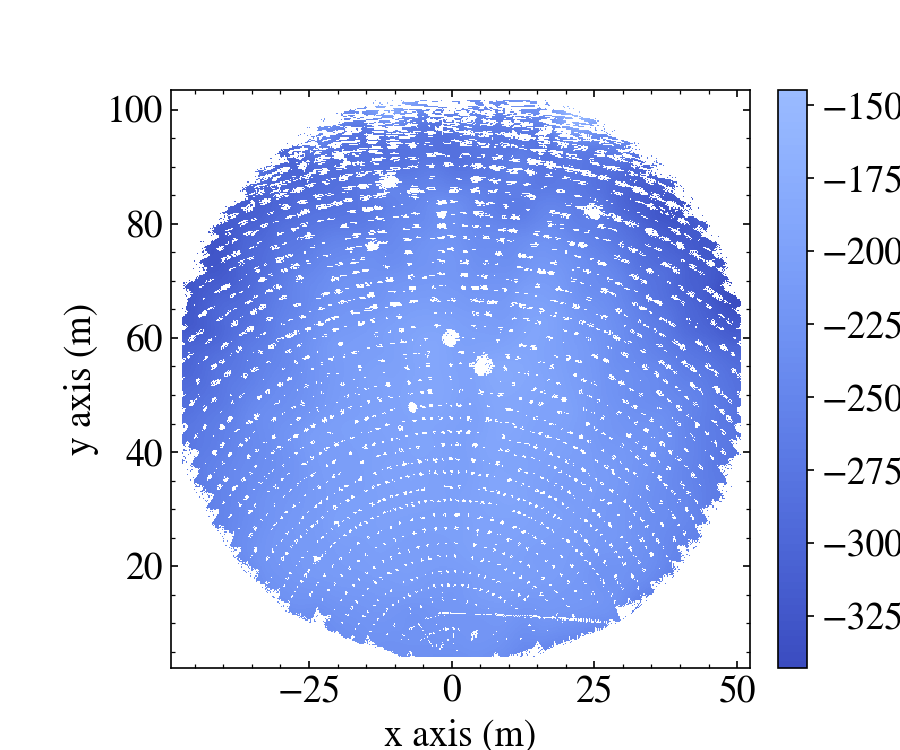

CPU times: user 2.89 s, sys: 41.1 ms, total: 2.93 s
Wall time: 2.92 s


In [157]:
%%time
fl_fs_sub = np.copy(fl_fs)
diff_ = np.ma.copy(smdiff)
it = 0
while np.any(abs(fl_fs_sub[2:4]) > 100e-6):
    fl_fs_sub[1] *= 0.
    fl_fs_sub[2] *= -1.
    zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:4])
    diff_ = diff_ - zpoly_
    #fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
    zfit = zernikeFitLS(xrag[~np.isnan(smdiff.filled(np.nan))], yrag[~np.isnan(smdiff.filled(np.nan))], 
                    smdiff[~np.isnan(smdiff.filled(np.nan))], np.zeros(36))
    fl_fs_sub = zfit.x
    it += 1
#zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:2])
#diff_ = diff_ - zpoly_
#fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
print("Number of iterations: {}".format(it))
barChartPlot(np.arange(1,36), fl_fs_sub[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs_sub[iz]*1e6)
surfacePlot(xrag, yrag, diff_.T*1e6, vMin=np.nanmin(diff_*1e6), vMax=np.nanmax(diff_*1e6))

Number of iterations: 2


<IPython.core.display.Javascript object>


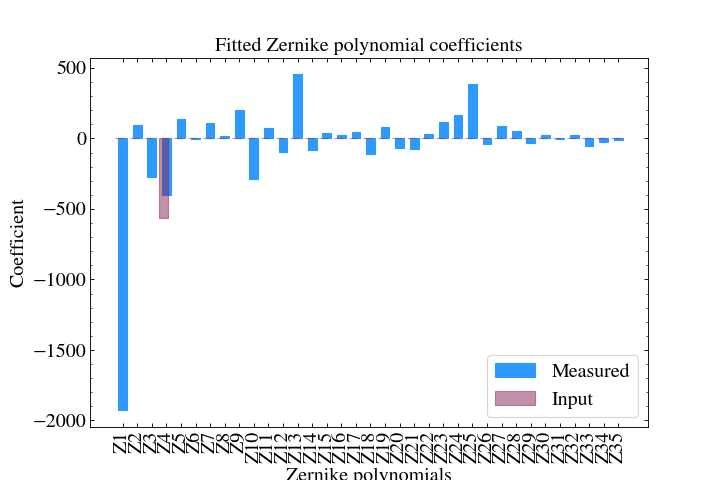

-398.49030939989217


<IPython.core.display.Javascript object>


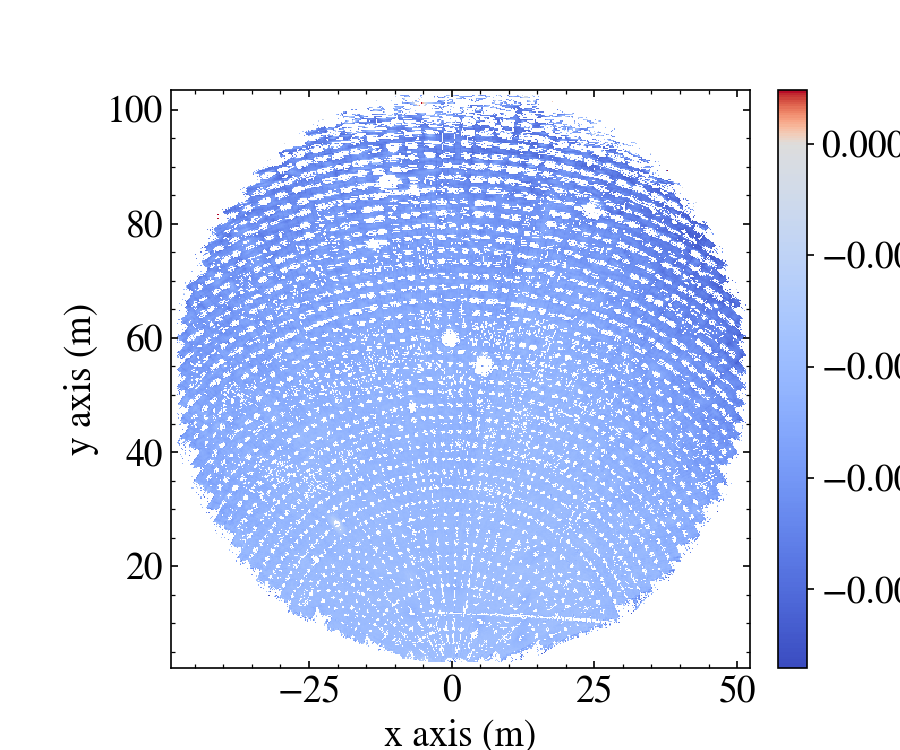

In [37]:
fl_fs_sub = np.copy(fl_fs)
diff_ = np.ma.copy(mdiff)
#it = 0
#while np.any(abs(fl_fs_sub[2:4]) > 100e-6):
fl_fs_sub[1] *= 0.
fl_fs_sub[2] *= 0.
zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:4])
diff_ = diff_ - zpoly_
fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
    #it += 1
#zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:2])
#diff_ = diff_ - zpoly_
#fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
print("Number of iterations: {}".format(it))
barChartPlot(np.arange(1,36), fl_fs_sub[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs_sub[iz]*1e6)
surfacePlot(xrag, yrag, diff_.T, vMin=np.nanmin(diff_), vMax=np.nanmax(diff_))

In [269]:
print(fl_fs_sub[4]*1e6)

-564.337023159537


In [84]:
fl_fs[4]*1e6, fl_fs_sub[4]*1e6

(-327.5348040179165, -250.14014398495263)

In [152]:
fl_fs[7]*1e6, fl_fs_[7]*1e6

(9.60704802083161, 52.96201764528141)

In [191]:
fl_fs[13]*1e6, fl_fs_[13]*1e6

(-650.6369668810958, -608.7690786711642)

In [154]:
# Ci's from March - October.
# Using the mask from the parabola fitter.
fl_diff = np.array([ 0.00000000e+00, -3.69288510e-03, -1.49139347e-05, -3.52637492e-03,
       -1.20384279e-03,  3.42504620e-04, -6.94333784e-05,  7.45391278e-05,
       -2.82334099e-04,  1.16525931e-03, -5.20602079e-04,  7.60481614e-05,
        1.18311862e-03,  1.32807415e-03, -1.31880599e-05,  2.32681778e-04,
       -1.04560218e-04, -2.81682910e-05,  4.20666148e-04,  6.30305870e-04,
        5.67510711e-04, -5.28192266e-04,  4.95492629e-04, -3.32781178e-04,
        4.04544300e-04,  1.03737866e-03,  1.47115401e-04, -3.54065880e-04,
       -8.38001315e-05,  5.29861377e-07,  4.91299950e-04, -8.66901157e-05,
       -1.52489921e-07,  6.29674463e-04,  1.86082374e-04,  1.90359416e-04,
        3.80229172e-04])
fl_diff_ = np.array([ 0.00000000e+00, -3.71682792e-03, -2.58358180e-03, -3.53105556e-03,
       -1.20566590e-03,  3.32335485e-04,  2.32908596e-04, -1.74258160e-05,
        6.81334059e-04,  1.18443492e-03, -5.05738044e-04,  8.65598384e-05,
        1.17520943e-03,  1.32925720e-03, -1.63907828e-04,  7.86179735e-05,
       -5.58908977e-05,  1.21431588e-04,  1.29821922e-03,  6.49889436e-04,
        5.64216358e-04, -5.14556665e-04,  4.96710125e-04, -2.91337239e-04,
        4.24701050e-04,  1.05750007e-03, -2.12268496e-05, -2.99363465e-04,
       -1.60039236e-04,  5.87575395e-05,  4.14361538e-04,  2.16738385e-06,
        7.72271937e-04,  6.51354892e-04,  1.96974470e-04,  2.07264460e-04,
        3.67381666e-04])

In [155]:
fl_diff = np.array([ 0.00000000e+00, -4.95066941e-03,  1.78990849e-04, -5.99716659e-03,
       -2.89161217e-04, -9.11323119e-04, -1.31885912e-05, -1.39847453e-04,
       -1.55114349e-04,  7.97151571e-04, -4.90269608e-04,  4.01070621e-04,
        5.87779993e-04,  7.49339935e-04, -2.38696729e-04,  1.78838369e-04,
        7.67140344e-05,  6.14181659e-05,  5.80052364e-04,  6.05003080e-04,
        3.27972954e-05, -7.81413338e-05,  5.99882342e-05, -1.03757820e-04,
        3.40930544e-04,  6.27484577e-04,  1.03829085e-04,  1.88756803e-06,
       -9.53187559e-05,  1.80298431e-05,  1.80692083e-04, -2.88046599e-04,
        2.60141989e-05,  6.34869244e-04,  9.62421357e-05,  4.56551029e-05,
        1.24674452e-04])
fl_diff_ = np.array([ 0.00000000e+00, -4.79423428e-03, -5.32398155e-03, -6.00016313e-03,
       -3.07888519e-04, -9.57284246e-04, -3.74535852e-05, -1.49184994e-04,
        6.28182959e-04,  8.18853488e-04, -4.76942360e-04,  4.32472011e-04,
        5.56862712e-04,  6.93640505e-04, -4.11982835e-04,  2.75246465e-05,
        1.16604493e-04,  1.98153847e-04,  1.53545303e-03,  6.52331555e-04,
        7.27764908e-05, -6.02058241e-05,  5.93541352e-05, -9.80896108e-05,
        3.00272224e-04,  5.79159840e-04, -1.37778391e-04, -6.20661561e-05,
       -2.18875209e-04,  2.69735536e-05,  2.03614890e-04, -1.35585651e-04,
        1.04023629e-03,  6.83742294e-04,  1.25574412e-04,  2.96015210e-05,
        1.04995170e-04])

In [156]:
(fl_fs[iz] - fl_diff[iz])*1e6, (fl_fs_[iz] - fl_diff_[iz])*1e6

(-1529.3145981917296, -1445.3541998599935)